In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

No GPU was detected. CNNs can be very slow without a GPU.


In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## What is a convolution?

In TF, each input image is typically represented as a 3D tensor of shape *[height, width, channels]*. A mini-batch is represented as a 4D tensor of shape *[mini-batch. height, width, channels]*.

The weights are represented as a 4D tensor of shape [*height of receptive field, width of receptive field, number of feature maps in previous layer, and bias terms*]

Breaking down the `tf.nn.conv2d`:
  - images is the input mini-batch (4D tensor)
  - filters is the set of filter (4D tensor)
  - strides, is equal to one but also takes a 1D array with 4 elements, where the two middle elements arethe vertical and horizontal stride, first and last must be 1's.
  - padding:
    "SAME": The conv layer will use zero padding if necessary. Output size is set to the number of input neurons divided by the stride, rounded up. Then zeros are added as evenly as possible around the inputs. When strides=1, the layers outputs will have the same width and height as its inputs, hence "SAME".
    "VALID": Does not use zero padding and may ignore some rows and cols to the bottom and right, depending on the stride. Every neuron's receptive field only lies with valid positions, hence the name.

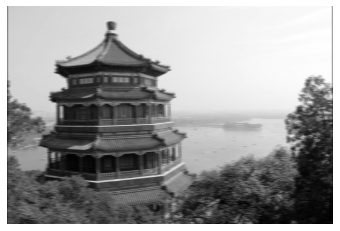

In [10]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7,7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, 
                       padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") #plot 1st image's 2nd feature map
plt.axis("off") #not shown in the book
plt.show()

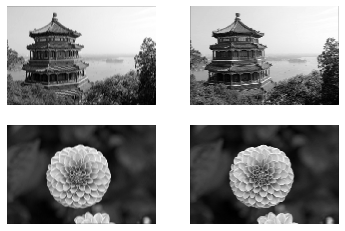

In [5]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index
                   + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [6]:
def crop(images):
    return images[150:220, 130:250]

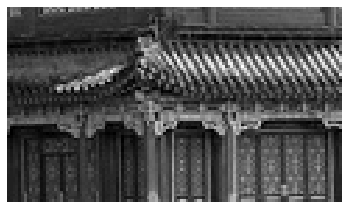

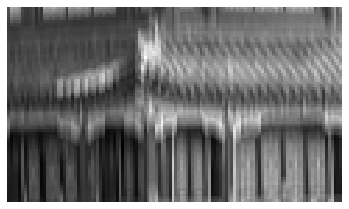

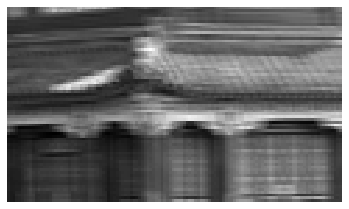

In [7]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical",
                                             "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

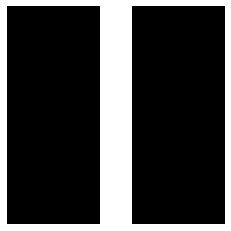

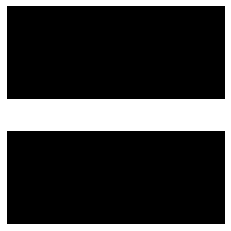

In [8]:
plot_image(filters[:, :, 0, 0])
plt.show()

plot_image(filters[:, :, 0, 1])
plt.show()

### Memory Requirements

CNN's are RAM intensive. During inference, the RAM of one layer can be released as soon as the next layer has been computed, so you only need two layers worth of RAM. **During training**, eveerything computed for the forward pass needs to be saved for the reverse pass, so it needs the amount of RAM of all layers.

Some things to try if getting memory crashes: reducing batch mini-size, reducing dimensionality with a stride, remove layers, convert 32bit floats to 16bit, or distribute the CNN across multiple devices.


## Pooling Layers

Their goal is to subsample or shrink the image to reduce computational load, memory usage, and number of parameters.

Pooling layer is connected to the outputs of a limited number of neurons in the previous layer, like conv layers. It has no weights, all it does is aggregate inputs with a function like max or mean. 

Stateless sliding windows when describing *pooling kernel*. 

*Max pooling layer* introduces some invariance to small differences in where th sliding window is (to translation of the window). This is good so the model isn't getting bogged down by details. However, this is destructive, it can remove a lot of input values.

The opposite of invariance is equivarience, in which a small change of the input leads to the same small change in outputs.

In [11]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [12]:
cropped_images = np.array([crop(image) for image in images],
                          dtype=np.float32)
output = max_pool(cropped_images)

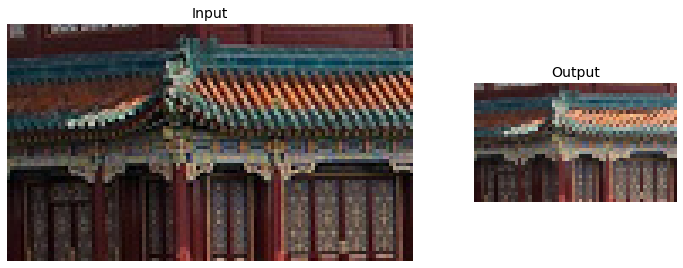

In [16]:
fig = plt.figure(figsize=(12,8))
gs = mpl.gridspec.GridSpec(nrows=1,ncols=2, width_ratios=[2,1])

ax1 = fig.add_subplot(gs[0,0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0]) #plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0,1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0]) #plot output for 1st image
ax2.axis("off")
plt.show()

### Depth-wise pooling

Generally, MaxPool is better than AvgPool because MaxPool only looks at the strongest features, has stronger translation invariance, cleaner signal, and slighlty less to compute. 

Pooling can also be done along the depth dimension rather than the spatial one, used uncommonly. Can help with being invariant to various features.

TF has a function that will can this. `tf.nn.max_pool`. The first three values of kernel size and strides should be one, that is, kernel size along batch, height, and width are 1. The last value will be across the depth dimension and it must be a divisor of the input depth or it wont work.

In [17]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID",
                **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                             ksize=(1,1,1,self.pool_size),
                             strides=(1,1,1,self.pool_size),
                             padding=self.padding)

In [20]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [21]:
# Using it as a Keras layer
# wrap it in a Lambda layer

depth_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(X,
                            ksize=(1,1,1,3),
                            strides=(1,1,1,3),
                            padding="VALID"))
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape


TensorShape([2, 70, 120, 1])

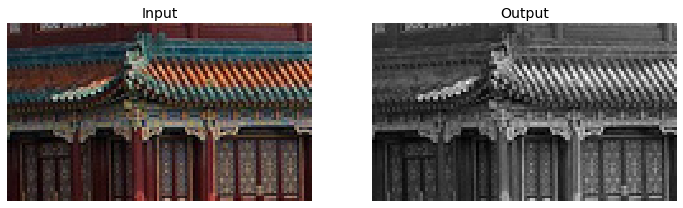

In [19]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])
plt.subplot(1,2,2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])
plt.axis("off")
plt.show()

### Average Pooling

In [23]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [24]:
output_avg = avg_pool(cropped_images)

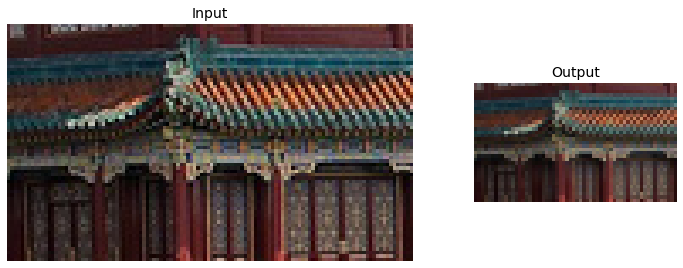

In [25]:
fig = plt.figure(figsize=(12,8))
gs = mpl.gridspec.GridSpec(nrows=1,ncols=2,width_ratios=[2,1])

ax1 = fig.add_subplot(gs[0,0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0]) 
ax1.axis("off")
ax2 = fig.add_subplot(gs[0,1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])
ax2.axis("off")
plt.show()

### Global Average Pooling

This is different from average pooling. It computes the mean of each entire feature map. It will output one number per feature map and per instance, which is highly destructive, but it is used successfully as an output layer in many architectures. 


In [26]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

In [27]:
output_global_avg2 = keras.layers.Lambda(lambda X:tf.reduce_mean(X, axis=[1,2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

## CNN Architectures

Typically they go, conv layer, ReLu, Pooling, conv layers + Relu, pooling, then a feedforward neural network, and a final output layer like softmax if its classification.

Common mistake: using convolution kernels that are too large. Instead of a 5 x 5, use two 3 x 3, less parameters, less to compute. Exception is the first Conv layer can have a large kernel with a stride of 2 or more.

In [28]:
(X_train_full, y_train_full),(X_test,y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

#np.newaxis creates a new axis and is equal to None
X_train = X_train[...,np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [29]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

#### Breakdown of above model:

First conv layers use 64 large filers (7 x 7) but no stride b/c input images aren't large. Input shape is [28, 28, 1], b/c input images are 28 x 28 and there is one color channel, greyscale.

Maxpooling has pool size of 2 so it divides each spatial dim by factor of 2.

Repeat the same structure twice, for larger images, can do this repetition more times. (Tunable in the sense that its by experiment to find the best structure)

The number of filters is growing in amount. Makes sense because you can combine the low-level featues like circles and whatevrs into more complex high-level features. Also common practice to double filters after every pooling layer, since we made it smaller with the pooling, dont have to worry about exploding the computational load. 

Last is fully connectd network, have to flatten the inputs first since dense networks expect 1D arrays, and also add dropout to avoid overfitting.




In [ ]:
'''#stopped training because its hella slow

model.compile(loss='sparse_categorical_crossentropy',
             optimizer="nadam",
             metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_valid,y_valid))
score = model.evaluate(X_test,y_test)
X_new = X_test[:10] #pretend these are new images
y_pred= model.predict(X_new)'''

#### Some CNN architecture history:

AlexNet introduced *local response normalization* which in like biological neurons, strongly activated neurons inhibit other neurons located in the same position in neighbouring feature maps. Encourages specialization.

GoogLeNet used *inception modules* to use parameters more efficiently and allowed it to go deeper than AlexNet. The diagram is very explanatory (pg 467).
(adding a lot more conv kernels hyperparameters to tweak with an inception module)

### ResNet-34

In [33]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3,
                       strides=1, padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self,filters,strides=1,activation="relu",
                **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layer= [
            DefaultConv2D(filters,strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters,kernel_size=1,strides=strides),
                keras.layers.BatchNormalization()]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layer:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [34]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64,kernel_size=7, strides=2,
                       input_shape=[224,224,3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2,
                                padding="SAME"))
prev_filters = 64
# loop here just repeats 64 3 times, 128 4 times and so on
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_3 (ResidualUni (None, 56, 56, 64)       